# Comparing ConFair to OMN in their relationship between input degree and fairness improvement

In [3]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pipeline.utils import read_json, make_folder

## Read results from disc

In [5]:
repo_dir = sys.path[0].replace('notebooks', '')
eval_path=repo_dir+ 'eval/'

In [6]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        if x.iloc[0] in ['ERRDiff', 'FNRDiff', 'FPRDiff']: # measures with lower value means better
            if x.iloc[1] > 0: 
                return 0
            else: # G0 has better outcome
                return 1
        else: # for measures like eqdiff, avgoddsdiff with higher value means better
            if x.iloc[1] < 0: 
                return 0
            else: # G0 has better outcome
                return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [7]:
models = ['LR']

datasets = ['meps16', 'lsac']
targets = ['DI', 'FPR', 'FNR']

In [8]:
eval_file = 'degree-eval.csv'

if os.path.exists(eval_path+eval_file):
    eval_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results at {}'.format(eval_path+eval_file))
else:
    # assuming results has been extracted by running the exec_degree.zsh
    print('Run "exec_degree.sh" first to run experiments!')

Read evaluation results at /Users/keyang/Projects/PubRepo/NonInvasiveTool4FairML/eval/degree-eval.csv


In [8]:
# normalize the metric for consistent visualization
eval_df['norm_value'] = eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
eval_df['norm_flag'] = eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

In [9]:
eval_df.head()

,data,model,seed,method,target,alpha_g1_y1,alpha_g1_y0,alpha_g0_y1,alpha_g0_y0,group,metric,value,norm_value,norm_flag
0,meps16,LR,1,SCC-KAM,DI,1.0,1.0,0.01,-0.01,all,AUC,0.742000,0.742000,0
1,meps16,LR,1,SCC-KAM,DI,1.0,1.0,0.01,-0.01,all,ACC,0.818000,0.818000,0
2,meps16,LR,1,SCC-KAM,DI,1.0,1.0,0.01,-0.01,all,SR,0.222364,0.222364,0
3,meps16,LR,1,SCC-KAM,DI,1.0,1.0,0.01,-0.01,all,BalAcc,0.741536,0.741536,0
4,meps16,LR,1,SCC-KAM,DI,1.0,1.0,0.01,-0.01,all,ERR,0.182000,0.182000,0


## Draw scatter plots

In [10]:
def scatter_plots_group(file_suffix, df, vis_method, vis_dataset, target, x_col, vis_metric_group, vis_metric_all, x_ticks,
                        y_line=None, y_line_label=None, marker_size=50, line_width=2, x_max=None, y_min=None, x_ticks_label=None,
                        legend_names=None, font_label=26, font_legend=18, groups=['G0', 'G1', 'all'], 
                        colors=['#FF5733', '#3335FF', '#33FFBD'], bg_color = '#f3f3f3', marks=['^', 's', 'o'],
                        y_label=None, x_label=None, legend=True, legend_col=3, save_to_disc=True, plot_path = 'intermediate/evals/plots/'):

    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    
    vis_df = df[(df['data']==vis_dataset) & (df['target']==target)]

    metrics = [vis_metric_group, vis_metric_group, vis_metric_all]
    line_y = []
    line_x = []
    for x_i in x_ticks:
        for group_i, metric_i, color_i, mark_i in zip(groups, metrics, colors, marks):
            if x_i == 0:
                x_df = vis_df[(vis_df['group']==group_i) & (vis_df[x_col]==x_i) & (vis_df['metric']==metric_i) & (vis_df['method']=='ORIG')]
            else:
                x_df = vis_df[(vis_df['group']==group_i) & (vis_df[x_col]==x_i) & (vis_df['metric']==metric_i) & (vis_df['method']==vis_method)]
            
            y_values = np.array(x_df['norm_value'])
            y_avg = np.mean(y_values)
            n_reverse = sum(np.array(x_df['norm_flag']))
            
            if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
                edge_color = 'red'
            else:
                edge_color = 'black'
                
            if group_i == 'all' and ~np.isnan(y_avg):
                line_y.append(y_avg)
                line_x.append(x_i)
            else:
                ax.scatter(x_i, y_avg, color=color_i, marker=mark_i, edgecolors=edge_color, s=marker_size)

    ax.plot(line_x, line_y, '-', color=colors[-1:][0], linewidth=line_width, label=vis_metric_all)
    
    if legend_names:
        legends = legend_names
    else:
        legends = []
        group_name_map = {'G0': 'U', 'G1': 'W'}
        metric_map = {'SR': 'Selection Rate', 'FPR': 'FPR', 'FNR': 'FNR'}
        for m_i, g_i in zip(metrics, groups):
            if g_i == 'all':
                pass
            else:
                legends.append("{}'s {}".format(group_name_map[g_i], metric_map[m_i]))

        
    for color_i, mark_i, legend_i in zip(colors, marks, legends):
        ax.scatter(min(x_ticks)-1, max(x_ticks)+1, color=color_i, marker=mark_i, s=marker_size+8, edgecolors='black', label=legend_i)
    
    
    if y_line is not None:
        # add additional line
        ax.plot([-1, max(x_ticks)+1], [y_line, y_line], color='#4166f5', linewidth=1.5, label=y_line_label)
    
    
    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    
    if x_max is not None:
        plt.xlim([min(x_ticks)-0.01, x_max+0.01])
    else:
        plt.xlim([min(x_ticks)-0.01, max(x_ticks)+0.01])
        
    if x_ticks_label is not None:
        plt.xticks(x_ticks_label, fontsize=font_label, rotation=45) #[x for x in x_ticks if x%2==0], 
    else:
        plt.xticks([v for i, v in enumerate(x_ticks) if i%10==0], fontsize=font_label, rotation=45)
        
    if y_min is not None:
        plt.ylim([y_min, 1.01])
    else:
        plt.ylim([0.0, 1.01])
    plt.yticks(fontsize=font_label)

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig('{}{}_{}{}.png'.format(plot_path, vis_dataset, target, file_suffix), bbox_inches="tight")
#         print('Scatter plot is saved at {}{}_{}{}.png'.format(plot_path, vis_dataset, target, file_suffix))
        

In [11]:
plot_path = repo_dir+ 'intermediate/plots/target/'
make_folder(plot_path)

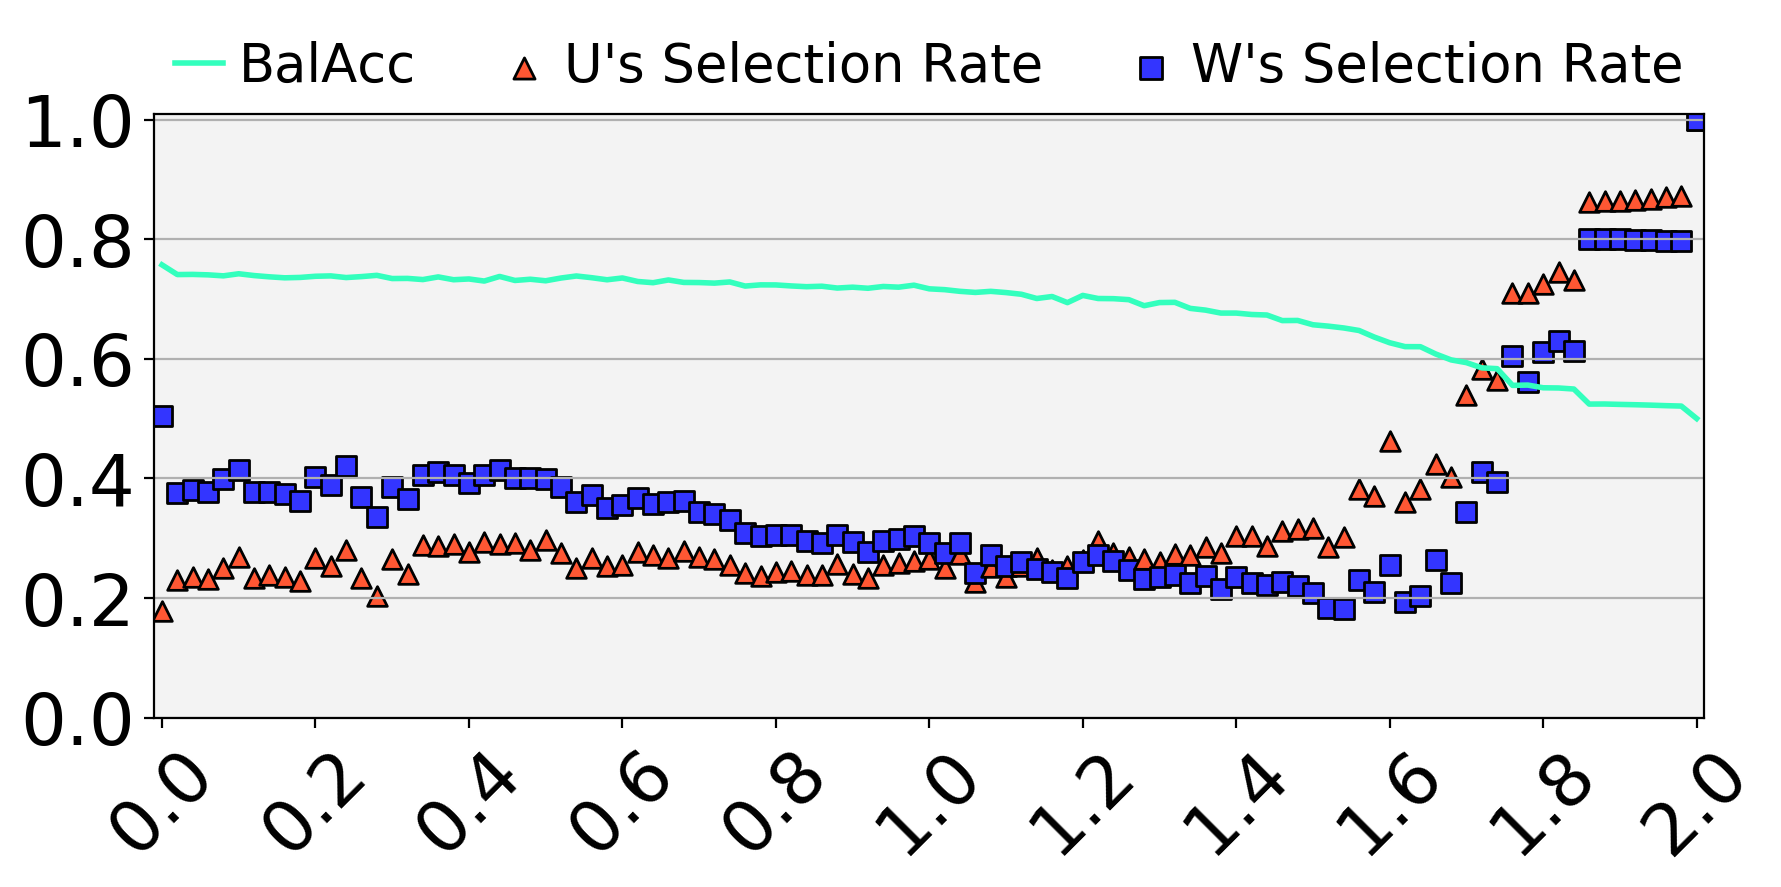

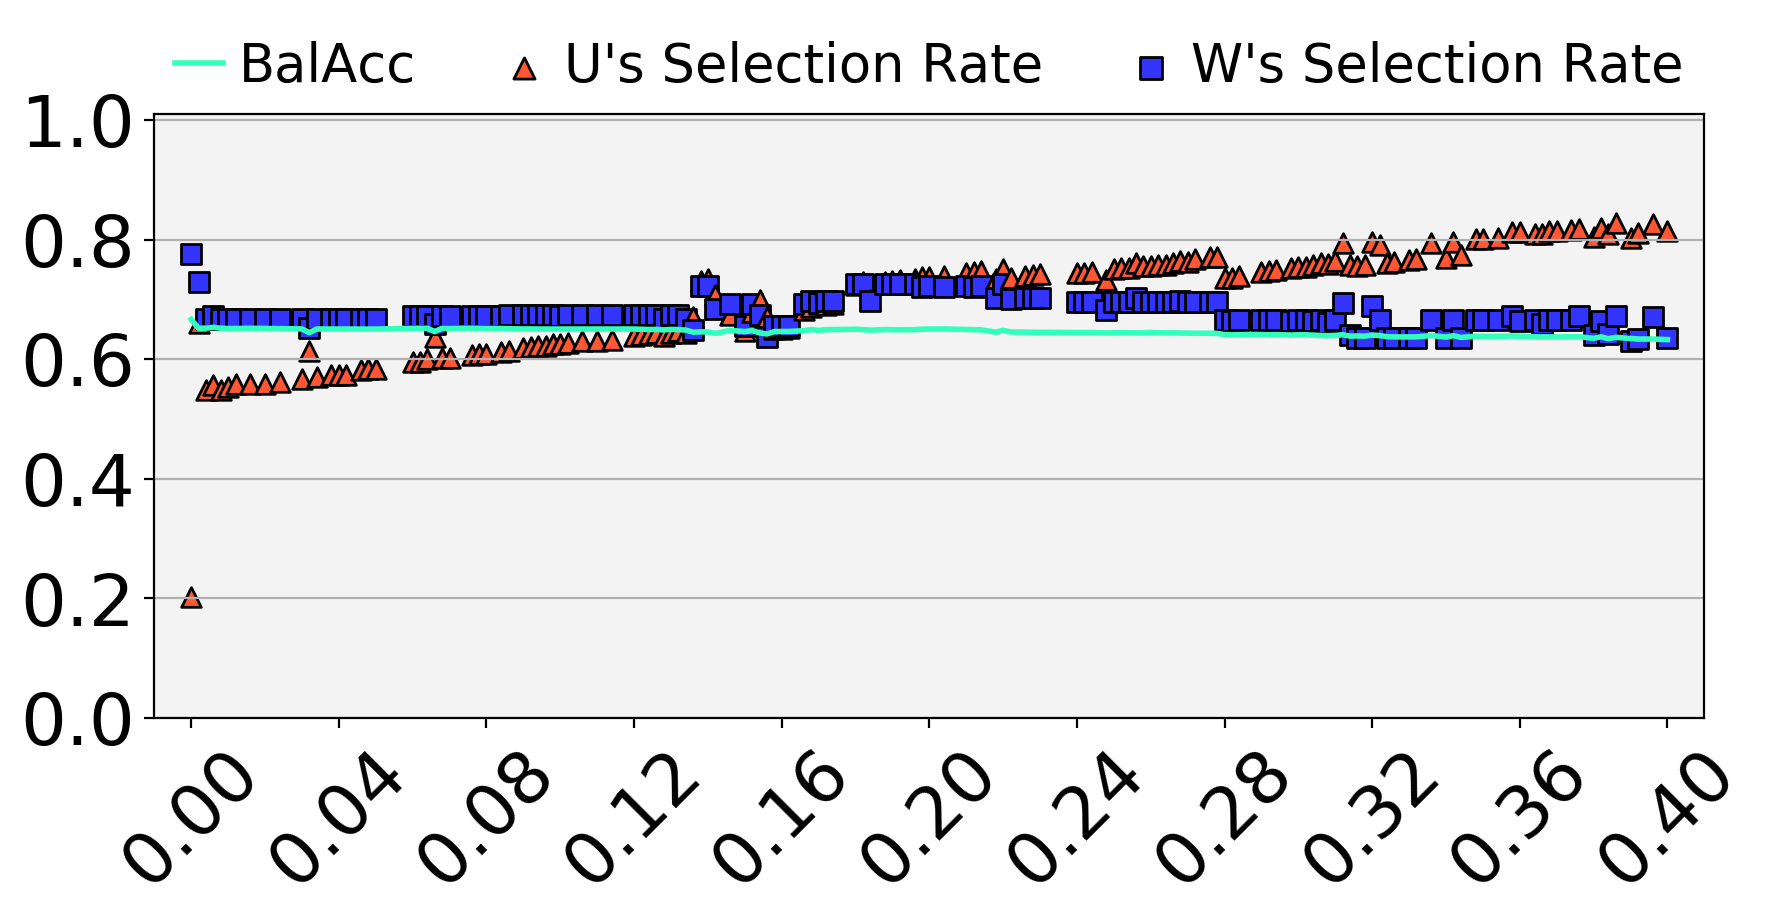

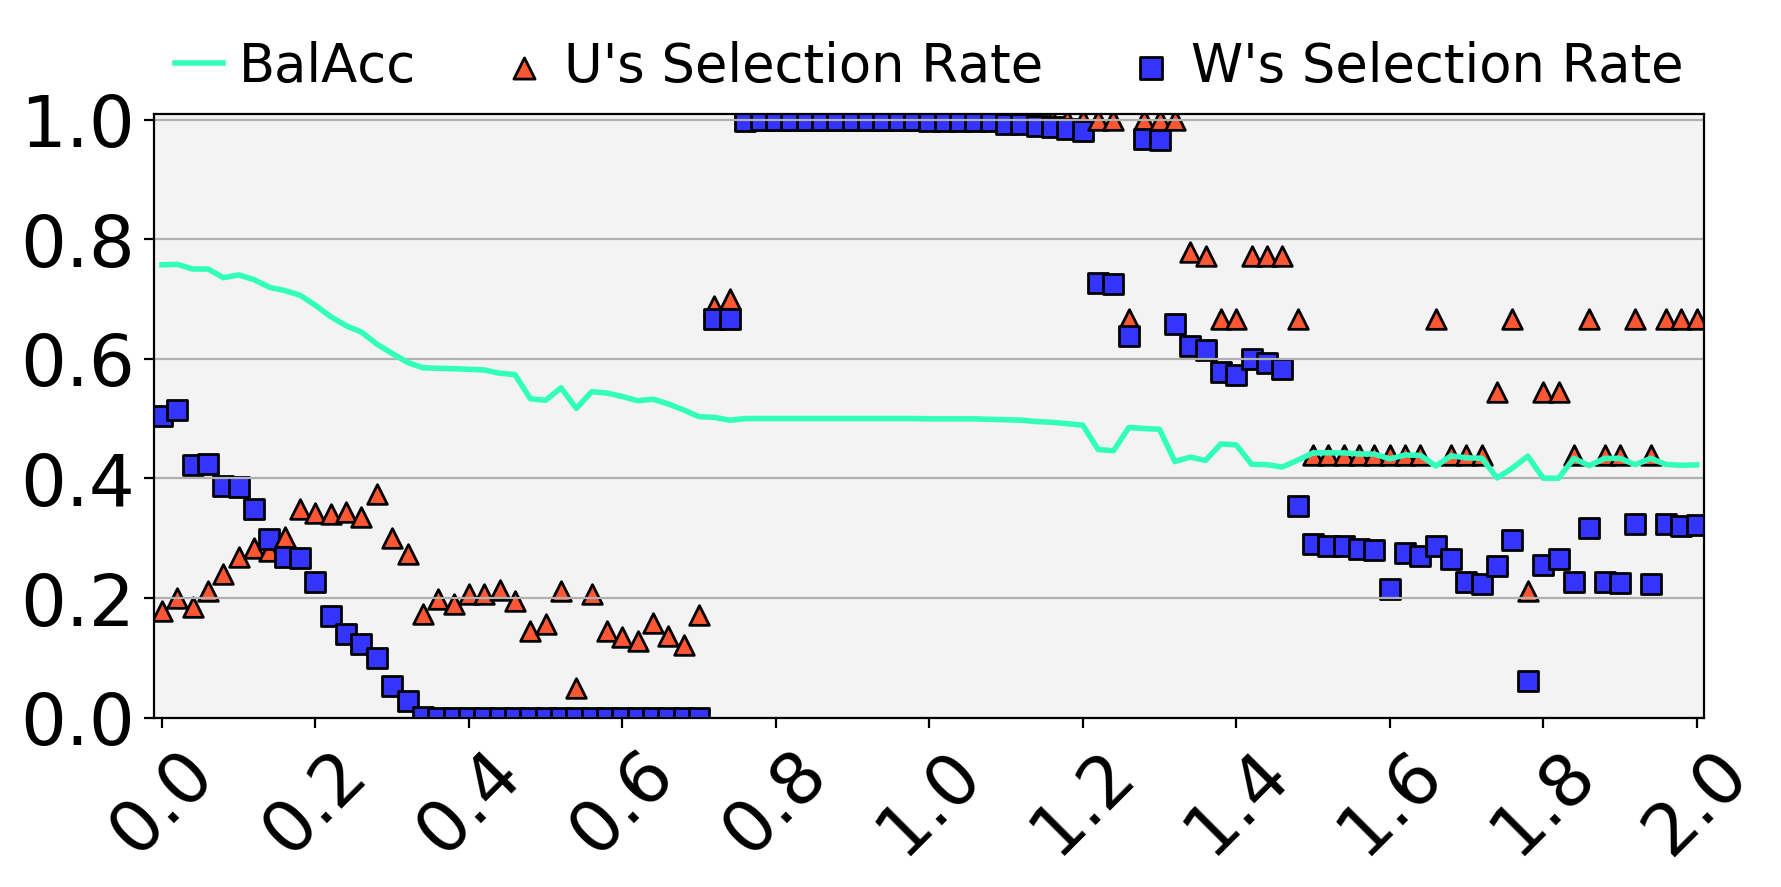

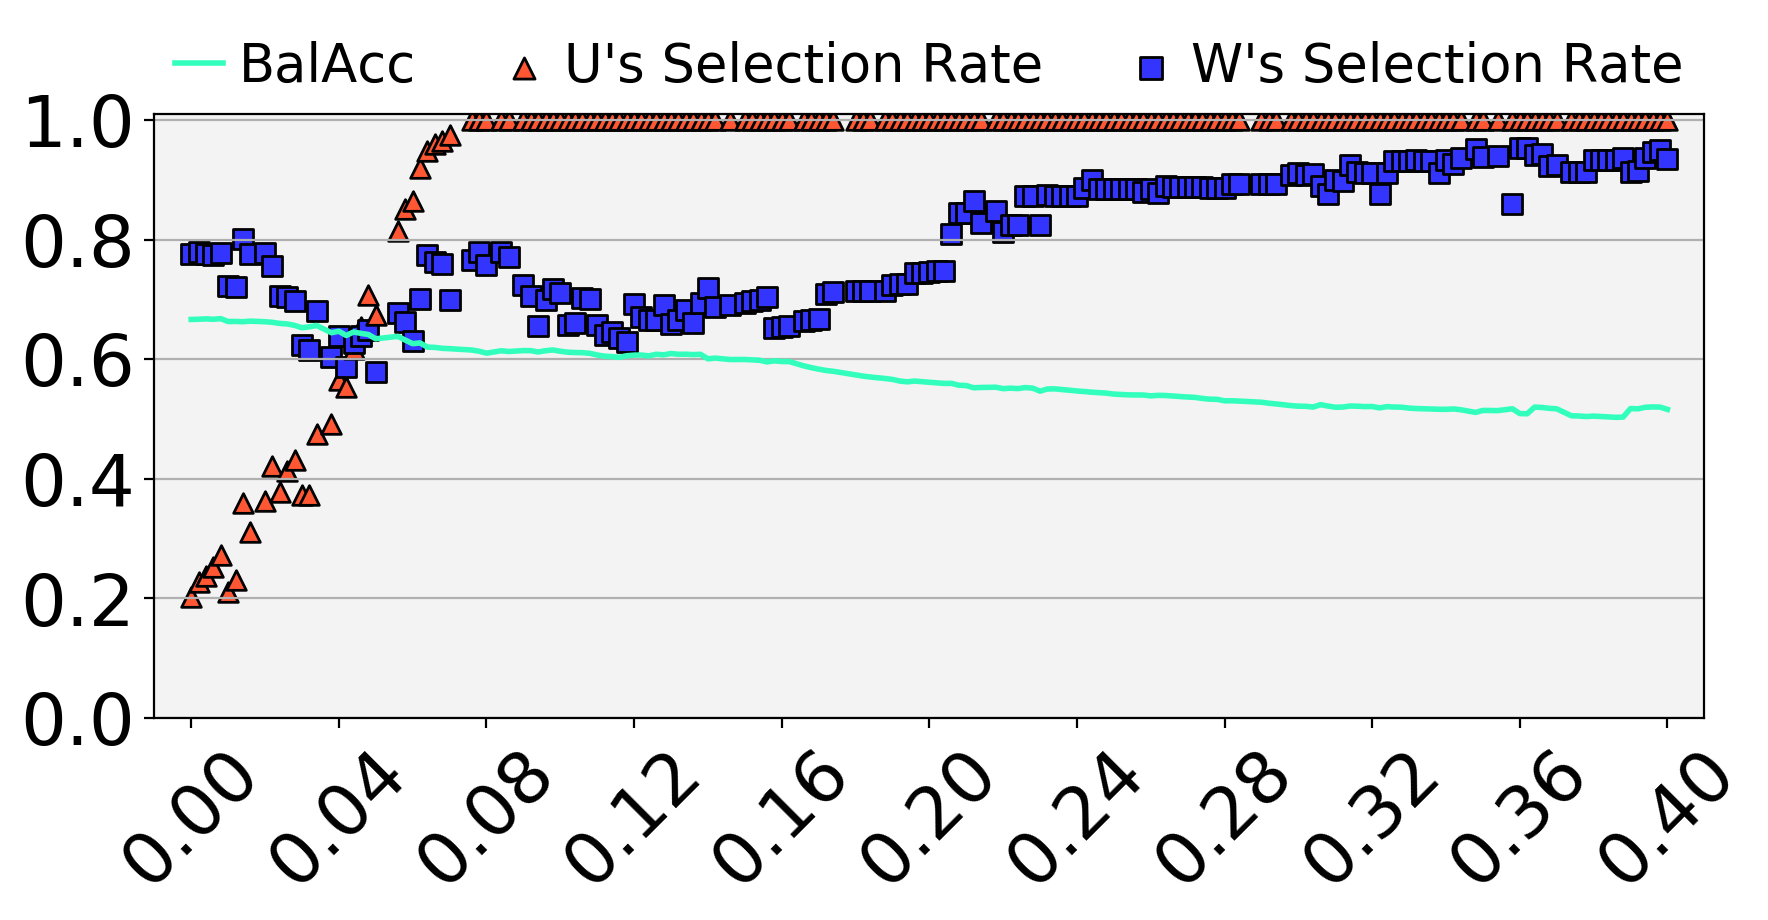

In [12]:
methods = ['SCC-KAM', 'OMN-ONE']
file_suffixes = ['_scc', '_omn']


exp_target = 'DI' # fairness metric only used for naming purpose

exp_metric_g = 'SR' # metric for group performance
exp_metric_all = 'BalAcc' # utility metric

exp_x_col = 'alpha_g0_y1' # visualize degree

for exp_method, file_suffix in zip(methods, file_suffixes):
    
    for exp_data in datasets:
        if exp_data == 'meps16':
            x_max = 2
            y_min = None
            x_ticks = [x / 100 for x in range(0, 201) if x%2==0]
            x_ticks_label = [x / 100 for x in range(0, 201) if x%20==0]
        else: # lsac
            x_max = None 
            y_min = 0
            x_ticks = [x / 1000 for x in range(0, 401) if x % 2 == 0]
            x_ticks_label = [x / 1000 for x in range(0, 401) if x % 40 == 0]
        scatter_plots_group(file_suffix, eval_df, exp_method, exp_data, exp_target, exp_x_col, exp_metric_g, exp_metric_all, x_ticks,
                            x_label='', y_label='', x_max=x_max, y_min=y_min, x_ticks_label=x_ticks_label,
                            save_to_disc=True, plot_path=plot_path)


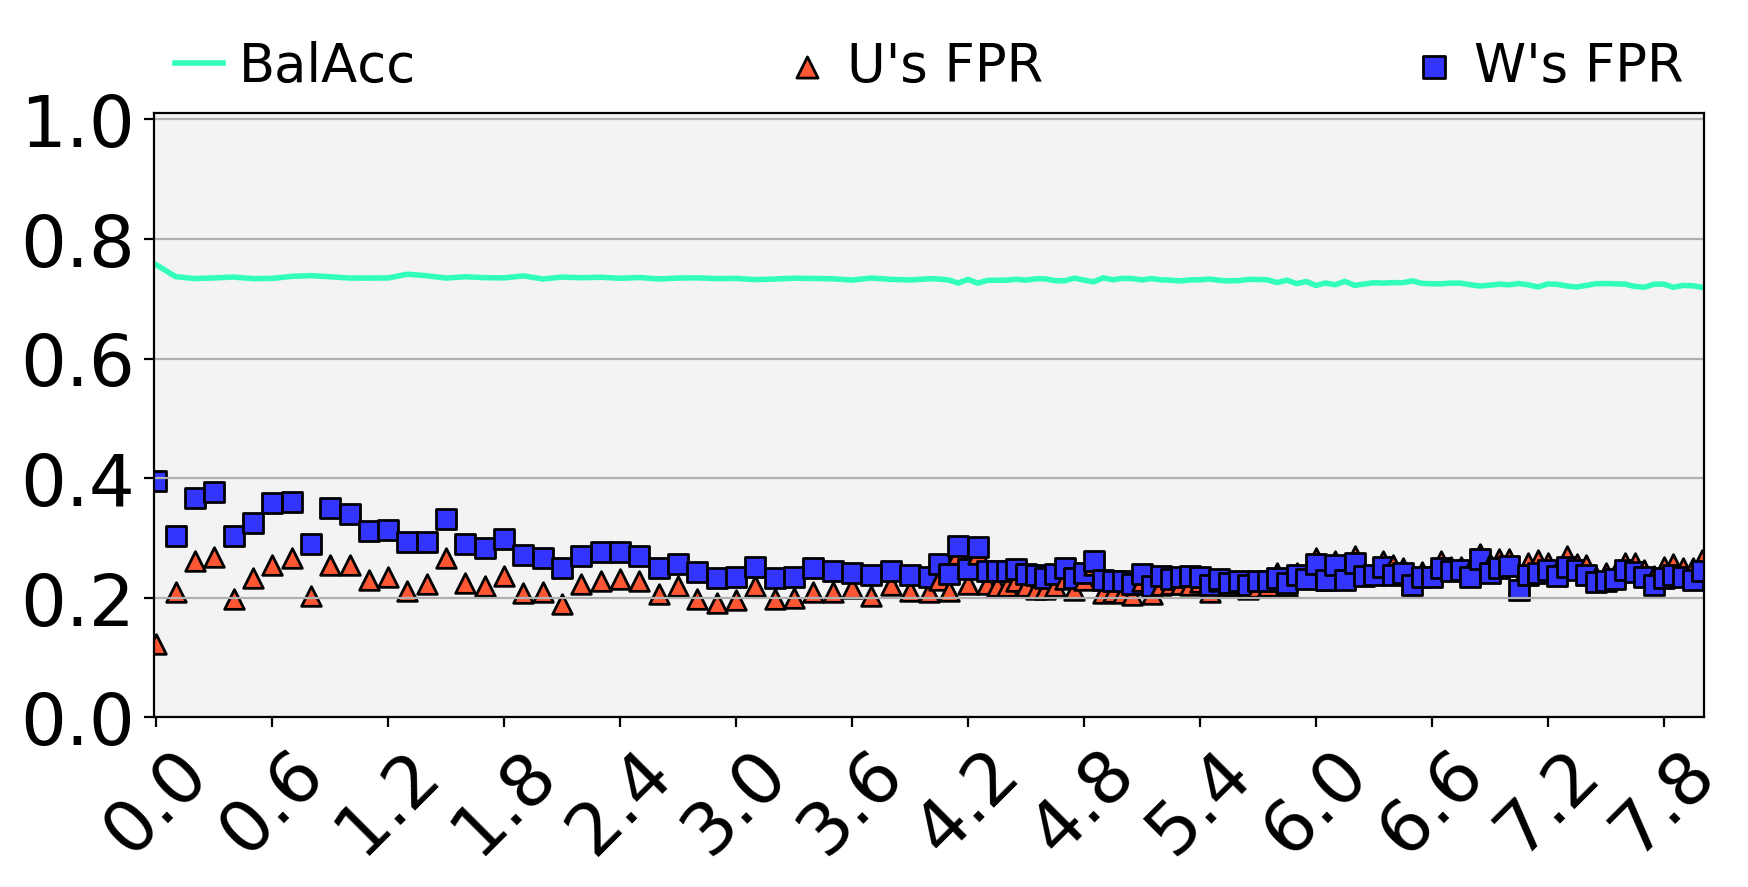

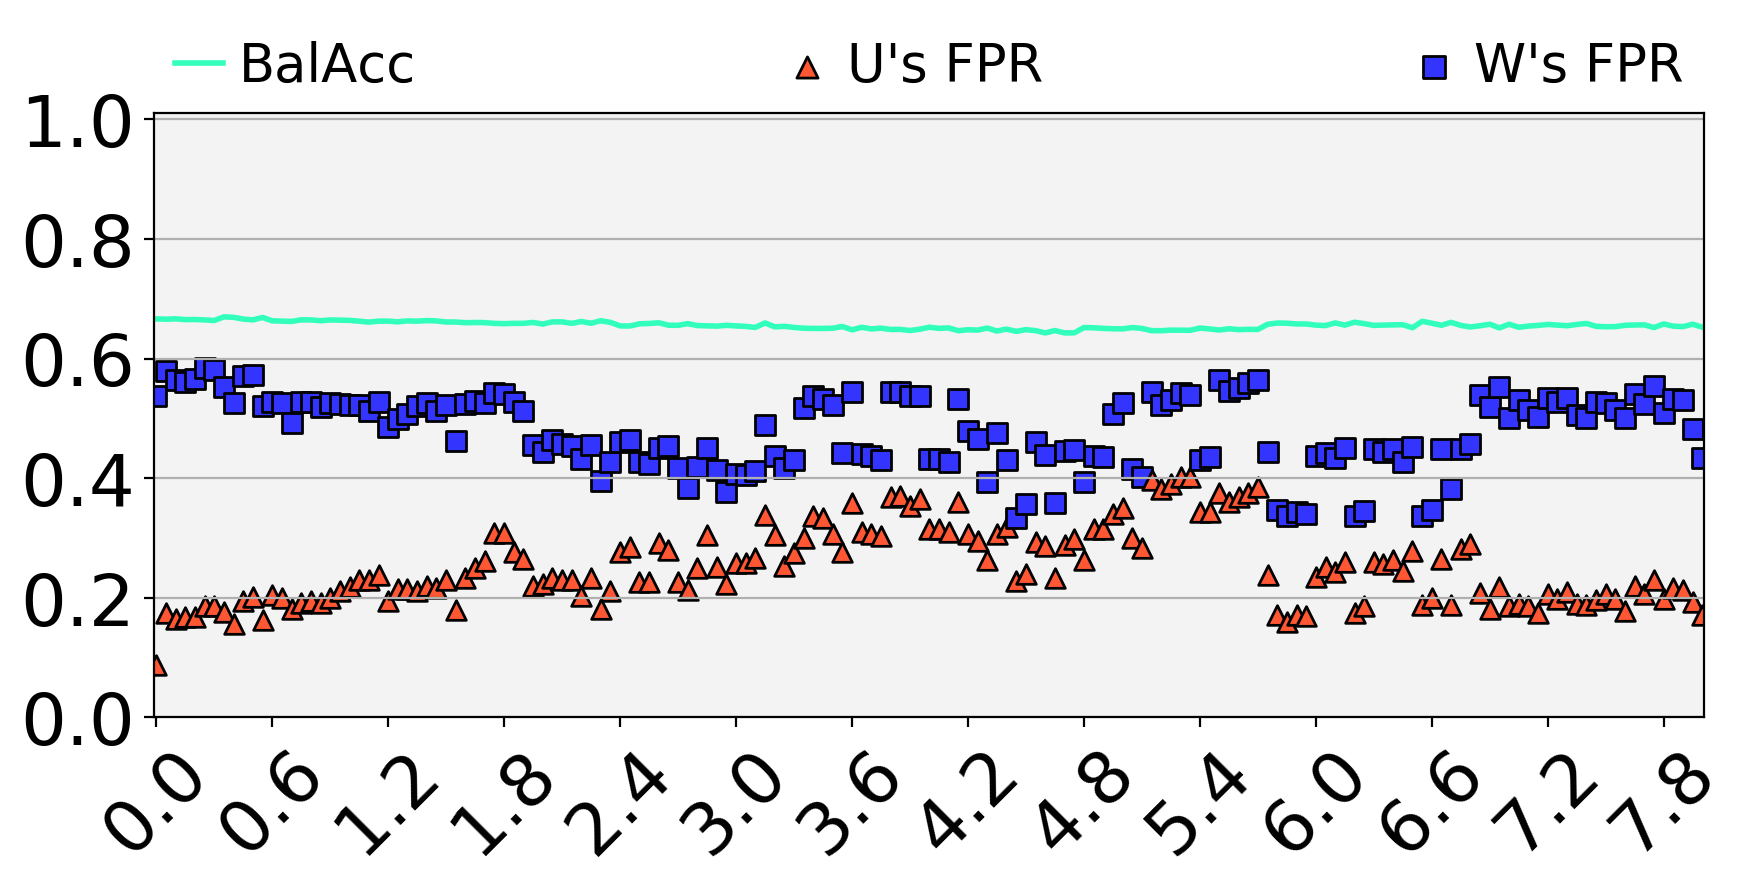

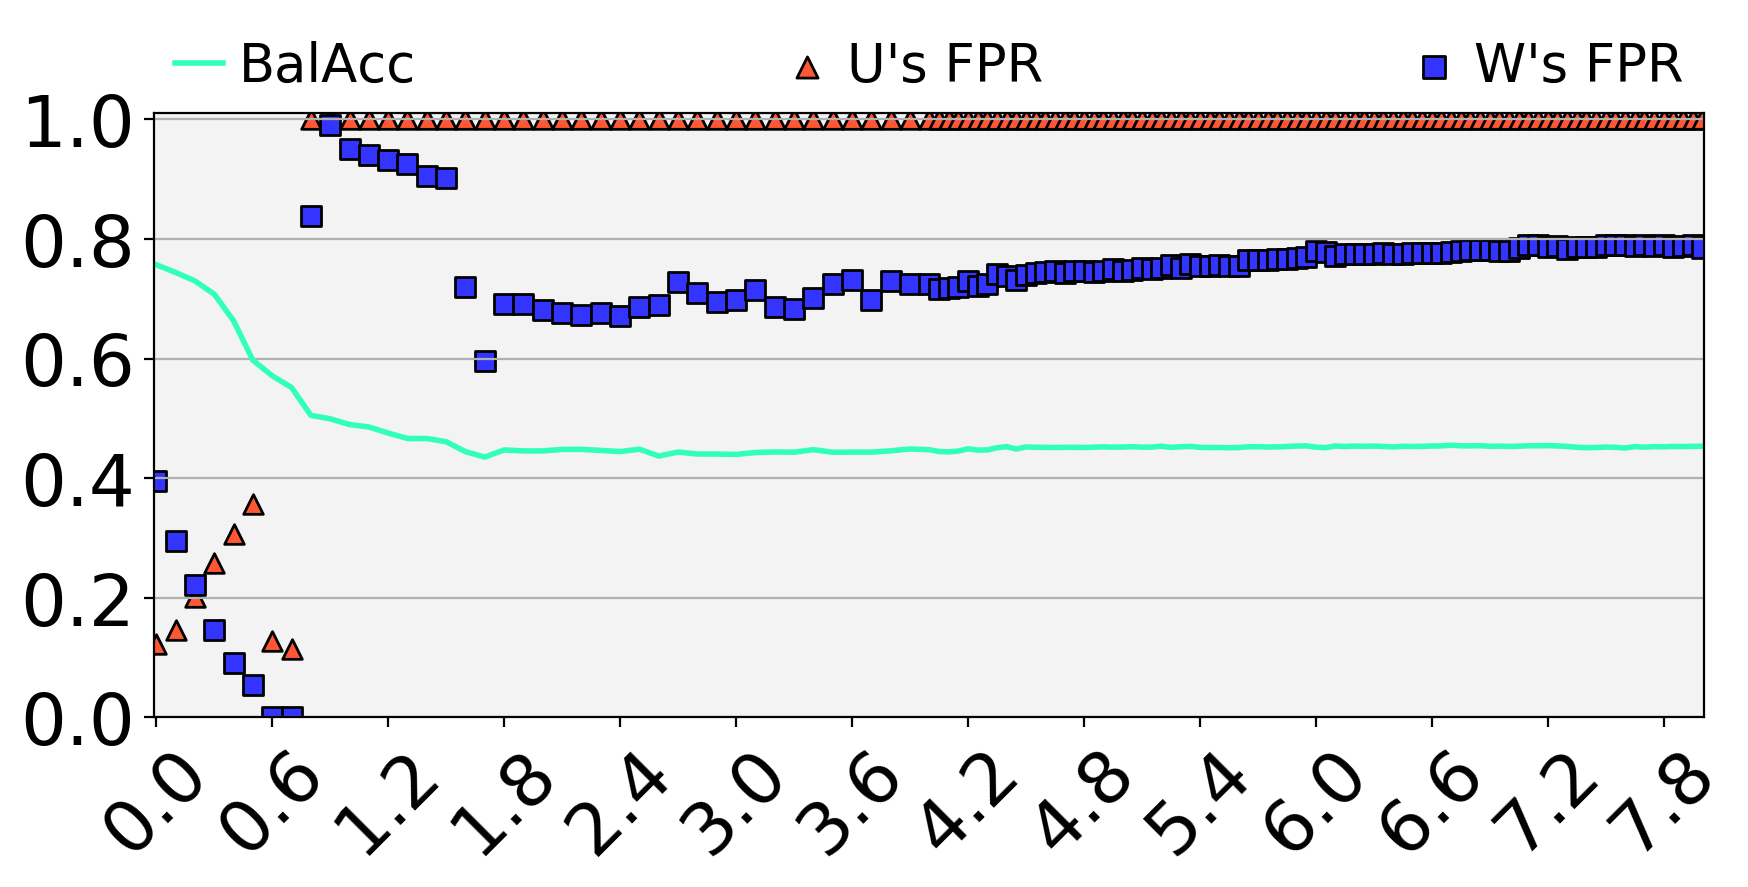

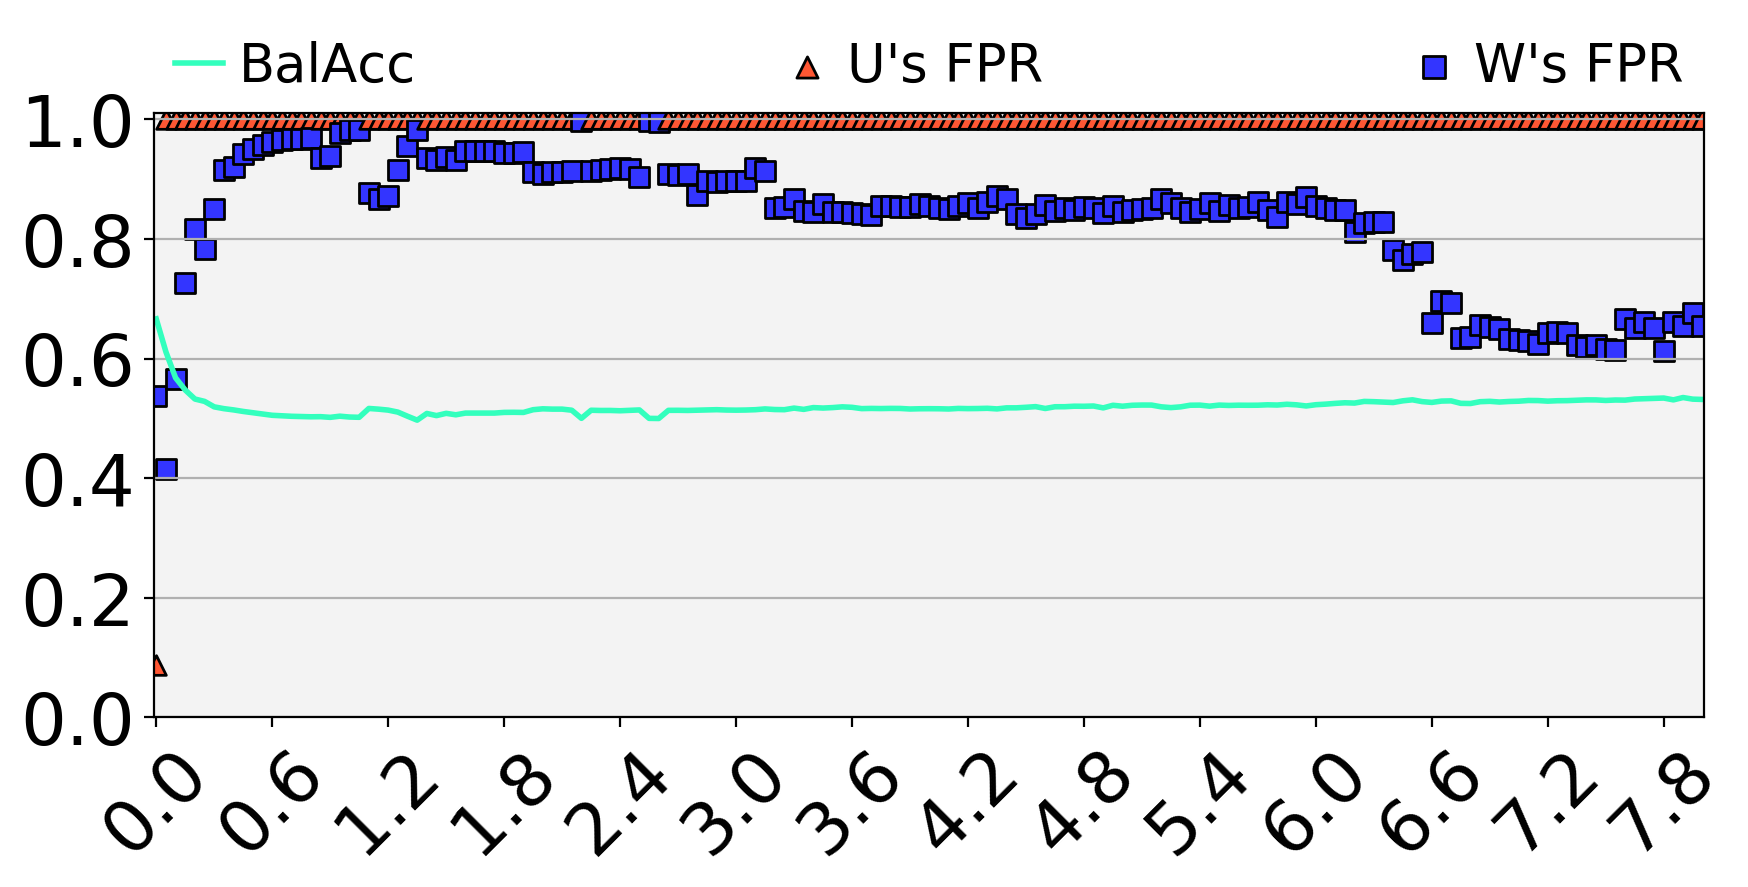

In [13]:
exp_target = 'FPR' # fairness metric only used for naming purpose

exp_metric_g = 'FPR' # metric for group performance
exp_metric_all = 'BalAcc' # utility metric

exp_x_col = 'alpha_g1_y0' # visualize degree


x_ticks_label = [x / 100 for x in range(0, 801) if x%60==0]

for exp_method, file_suffix in zip(methods, file_suffixes):
    for exp_data in datasets:
        if exp_data == 'meps16':
            x_ticks = [x / 100 for x in range(0, 401) if x%10==0] + [x / 100 for x in range(401, 801) if x % 5 == 0]
        else:
            x_ticks = [x / 100 for x in range(0, 801) if x % 5 == 0]
        scatter_plots_group(file_suffix, eval_df, exp_method, exp_data, exp_target, exp_x_col, exp_metric_g, exp_metric_all, x_ticks,
                            x_label='', y_label='', x_ticks_label=x_ticks_label,
                            save_to_disc=True, plot_path=plot_path)


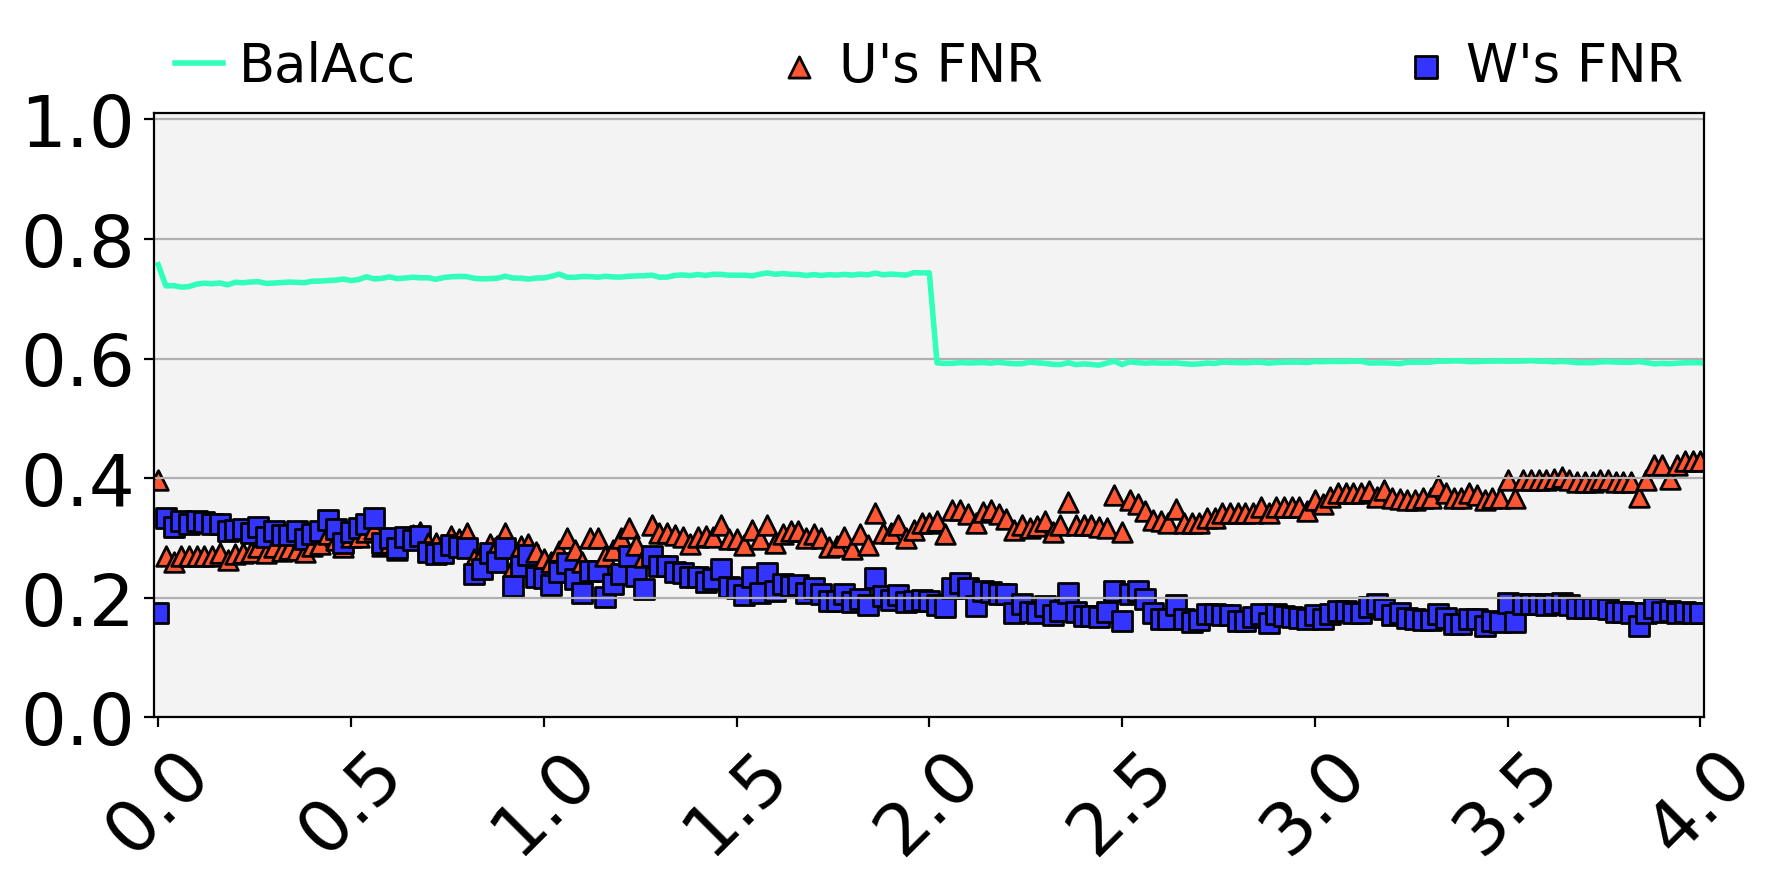

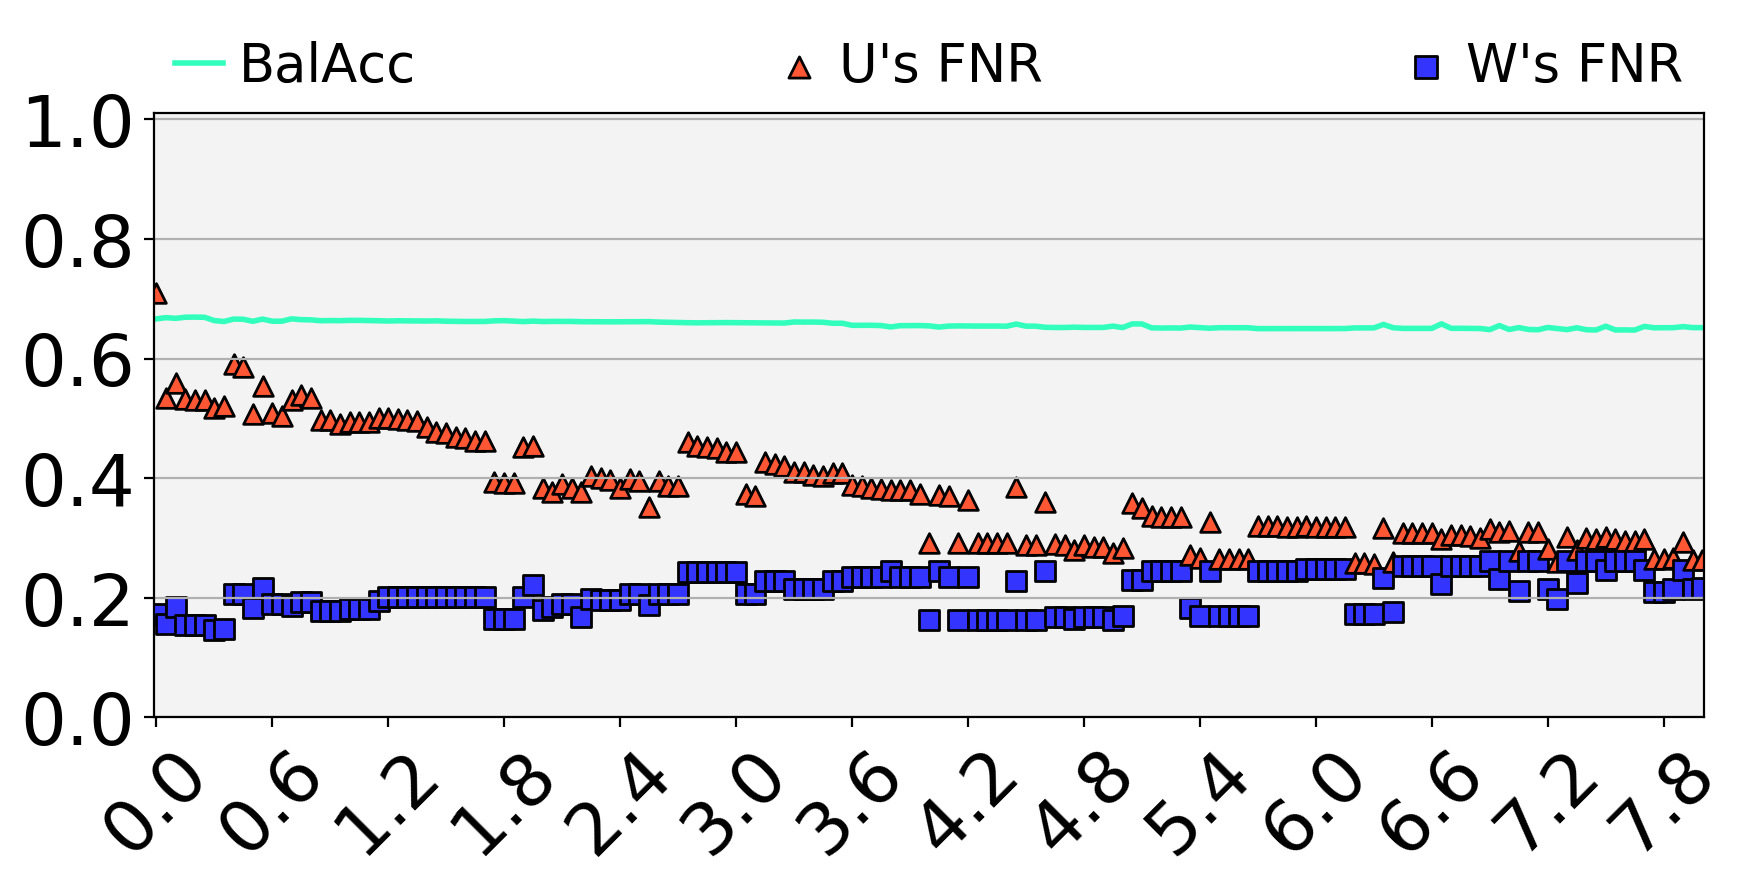

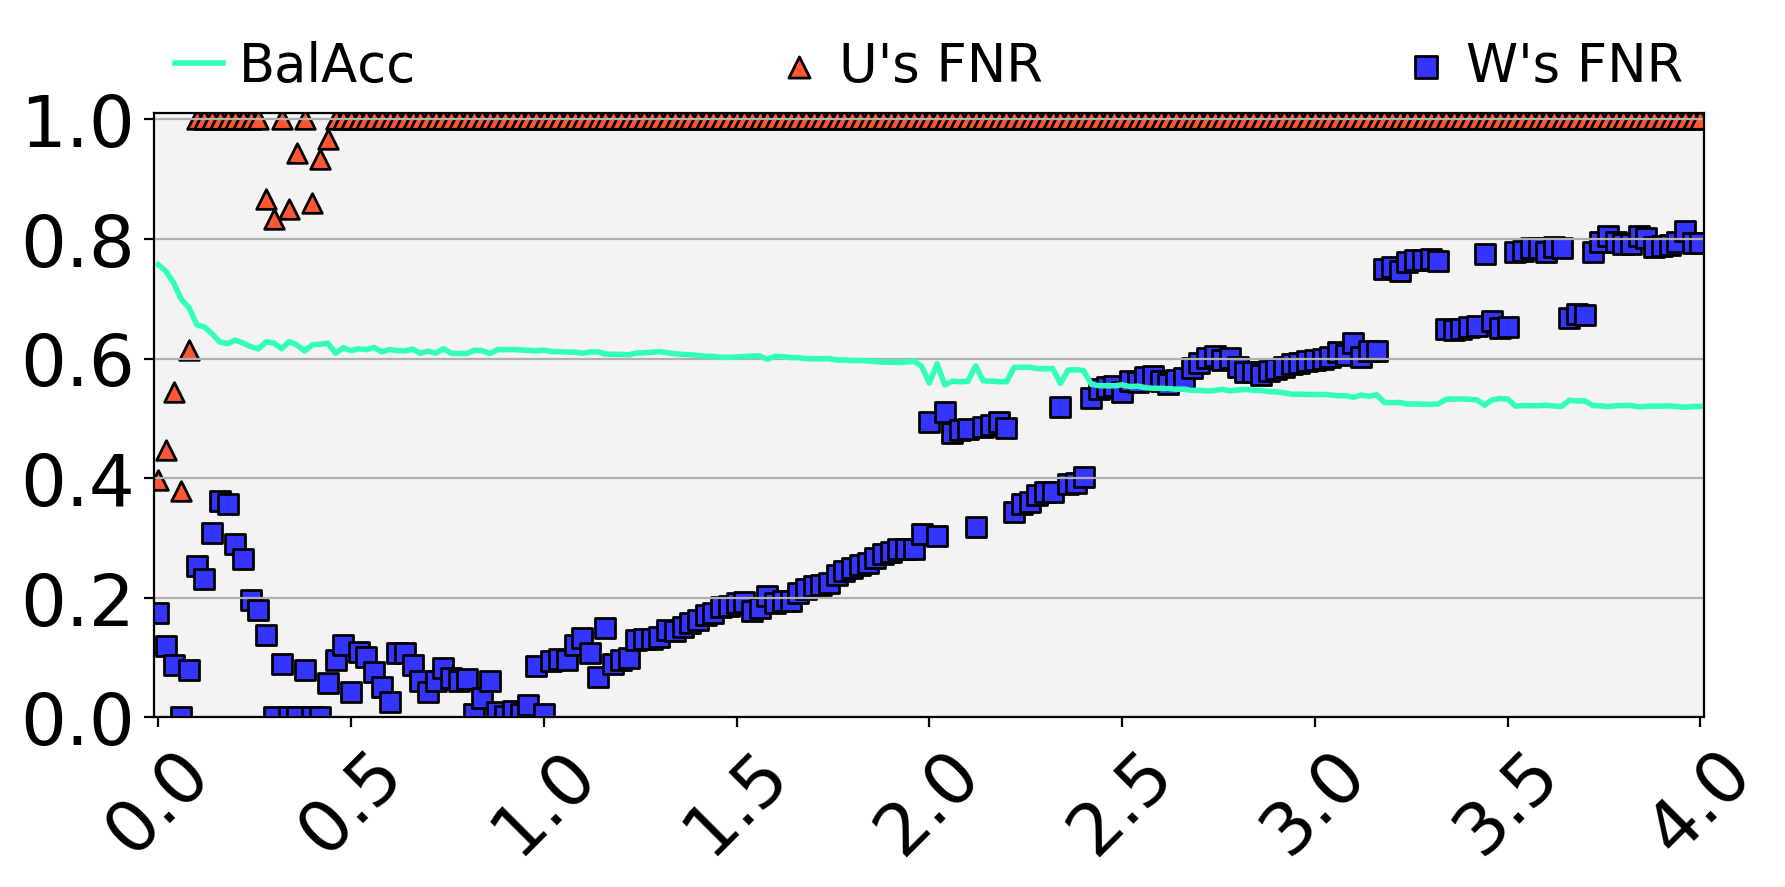

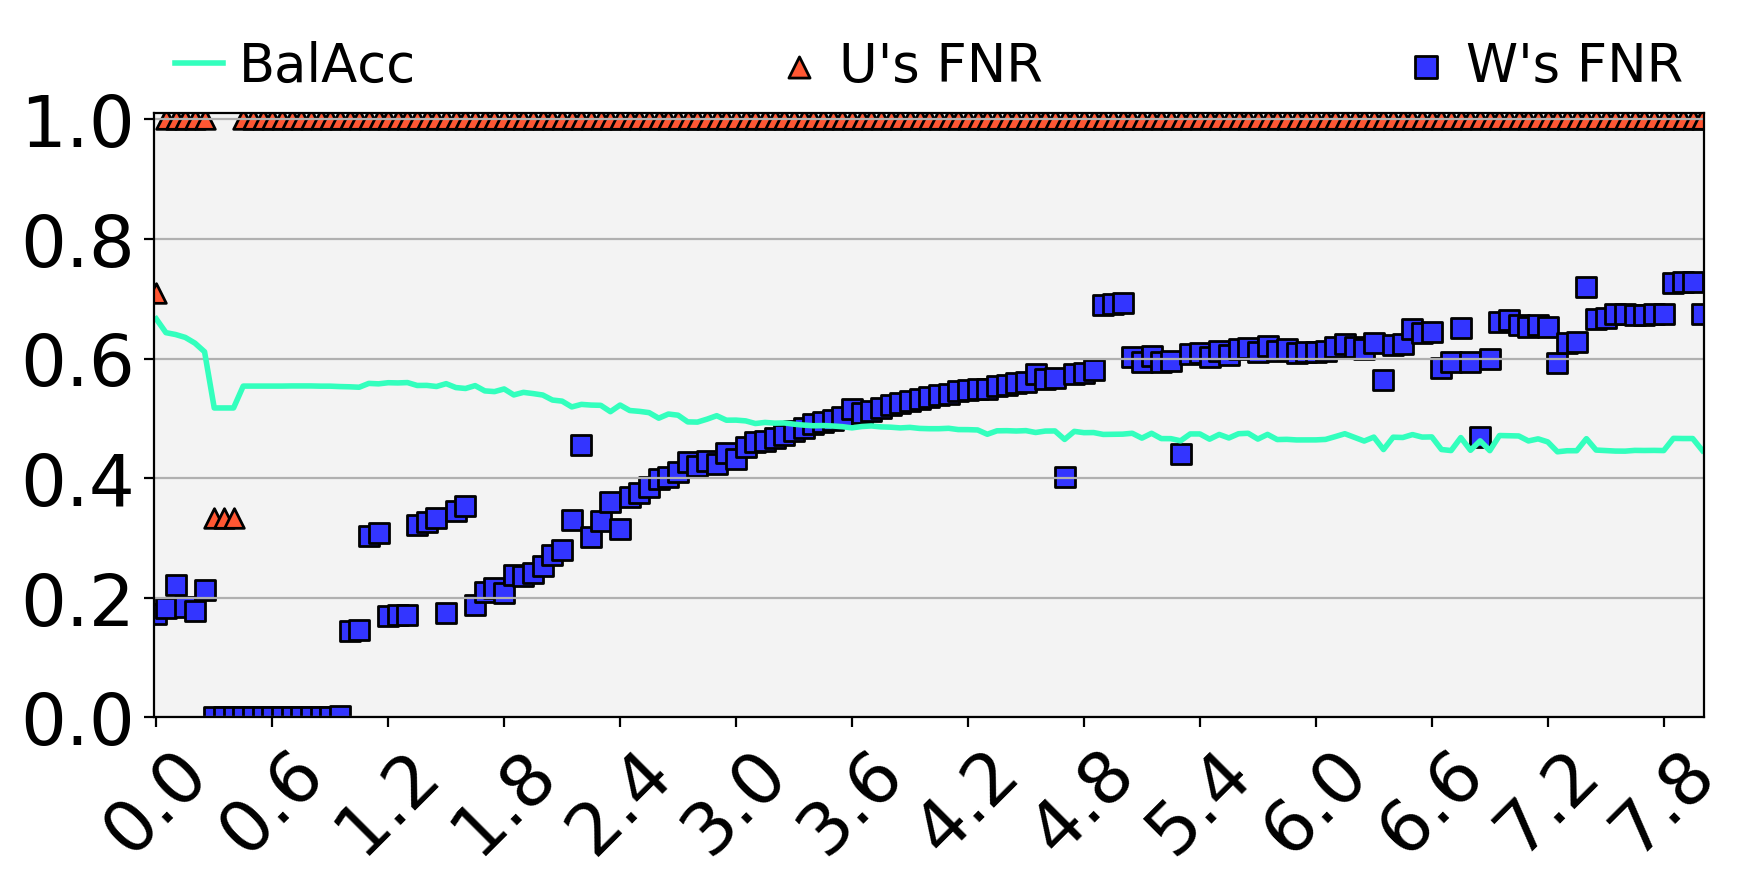

In [14]:
exp_target = 'FNR' # fairness metric only used for naming purpose

exp_metric_g = 'FNR'# metric for group performance
exp_metric_all = 'BalAcc' # utility metric

for exp_method, file_suffix in zip(methods, file_suffixes):
    for exp_data in datasets:
        if exp_data == 'meps16':
            exp_x_col = 'alpha_g1_y1'
            x_ticks = [x / 100 for x in range(0, 401) if x%2==0]
            x_ticks_label = [x / 100 for x in range(0, 401) if x%50==0]
        else: # lsac
            exp_x_col = 'alpha_g0_y1'
            x_ticks = [x / 100 for x in range(0, 801) if x % 5 == 0]
            x_ticks_label = [x / 100 for x in range(0, 801) if x%60==0]

        scatter_plots_group(file_suffix, eval_df, exp_method, exp_data, exp_target, exp_x_col, exp_metric_g, exp_metric_all, x_ticks,
                            x_label='', y_label='', x_ticks_label=x_ticks_label,
                            save_to_disc=True, plot_path=plot_path)
